In [1]:
!pip3 install -r requirements.txt

# **Import Library**

In [2]:
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# **Load and Clean Dataset**

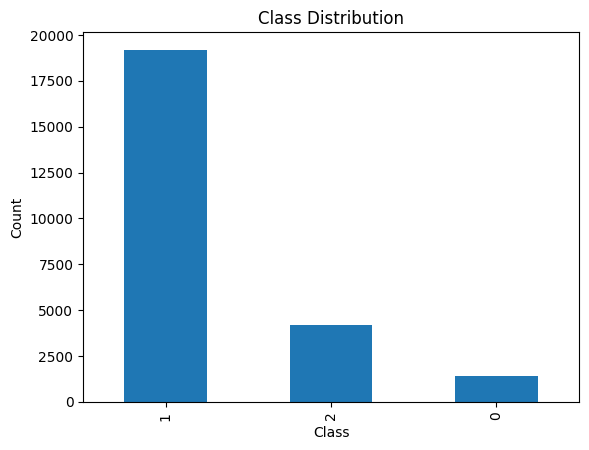

In [3]:
df = pd.read_csv("dataset/hate_speech.csv")

df['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [5]:
def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)                     # remove mentions
    text = re.sub(r'#\w+', '', text)                     # remove hashtags
    text = re.sub(r'&amp;', '&', text)                   # HTML entities
    text = re.sub(r'[^a-z\s]', '', text)                 # keep letters only
    text = re.sub(r'\s+', ' ', text).strip()             # normalize spaces
    return text

df["clean_tweet"] = df["tweet"].apply(clean_tweet)

# **Train/Test Split**

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_tweet"], df["class"], test_size=0.2, random_state=42, stratify=df["class"]
)

# **Tokenization**

In [7]:
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# **Torch Dataset**

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# **Load Model**

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Metrics**

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# **Training Setup**

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,     
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to=["tensorboard"],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# **Train Model**

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.299300,0.259885,0.913052,0.912396,0.911778,0.913052
2,0.228200,0.240808,0.920113,0.911176,0.909603,0.920113
3,0.190000,0.272862,0.914868,0.911097,0.909577,0.914868


TrainOutput(global_step=3720, training_loss=0.2391765881610173, metrics={'train_runtime': 988.0958, 'train_samples_per_second': 80.259, 'train_steps_per_second': 5.02, 'total_flos': 1528267564416600.0, 'train_loss': 0.2391765881610173, 'epoch': 3.0})

# **Evaluate Model**

In [13]:
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.24080781638622284, 'eval_accuracy': 0.9201129715553762, 'eval_f1': 0.9111758447806958, 'eval_precision': 0.9096027116852472, 'eval_recall': 0.9201129715553762, 'eval_runtime': 17.8674, 'eval_samples_per_second': 277.433, 'eval_steps_per_second': 8.675, 'epoch': 3.0}


In [14]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["Hate Speech", "Offensive", "Neither"]))



Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.59      0.28      0.38       286
   Offensive       0.93      0.97      0.95      3838
     Neither       0.91      0.90      0.90       833

    accuracy                           0.92      4957
   macro avg       0.81      0.72      0.74      4957
weighted avg       0.91      0.92      0.91      4957



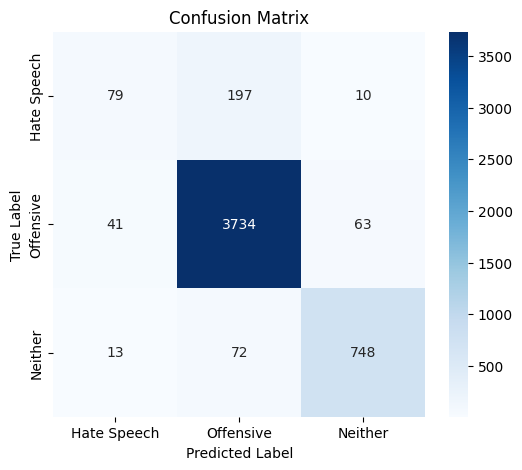

In [15]:
cm = confusion_matrix(labels, preds)
class_names = ["Hate Speech", "Offensive", "Neither"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Save Model**

In [16]:
model.save_pretrained("./models/model_1")
tokenizer.save_pretrained("./models/model_1")

('./models/model_1/tokenizer_config.json',
 './models/model_1/special_tokens_map.json',
 './models/model_1/vocab.txt',
 './models/model_1/bpe.codes',
 './models/model_1/added_tokens.json')

# **Prediction Function**

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "models/model_1"  
tokenizer = AutoTokenizer.from_pretrained(model_path)

model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

label_map = {
    0: "Hate Speech",
    1: "Offensive",
    2: "Neither"
}

def predict_tweet(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    
    return label_map[pred]

print(predict_tweet("I hate negroes and they should all go back to Africa."))
print(predict_tweet("You are stupid, I can't believe you did that."))
print(predict_tweet("What a beautiful day!, I love spending time outside."))


Hate Speech
Offensive
Neither
